# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [1]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [4]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cuda:0'

In [6]:
#!pip install ib_insync
#!pip install bs4
from ib_insync import *
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import quantstats as qs

In [17]:
from tqdm import tqdm

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [7]:
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

In [8]:
ib.run()

In [9]:
def extract_info(accounts, tag):
    for acc in accounts:
        if tag == acc.tag:
            return acc.value
    return None

In [10]:
account = ib.accountSummary()
print("Net worth:", extract_info(account, "NetLiquidation"))
print("Cash:", extract_info(account, "TotalCashValue"))

Net worth: 1050016.18
Cash: 943001.76


Top IT companies

In [26]:
TICKERS = [
    "NVDA", "MSFT", "AAPL", "TSLA",
    "META", "PYPL", "GOOG", "CRM",
    "INTC", "AMZN", "AMD", "BABA",
]

In [72]:
dfBars = pd.DataFrame()
for ticker in tqdm(TICKERS):
    stock = Stock(ticker, 'SMART', 'USD', primaryExchange='NASDAQ')
    bars = ib.reqHistoricalData(stock, endDateTime = '', durationStr = '1 M', barSizeSetting = '3 mins', whatToShow = 'ADJUSTED_LAST', useRTH = True, formatDate = 2)
    bars = util.df(bars)
    bars['tic'] = [ticker for _ in range(len(bars))]
    dfBars = pd.concat([dfBars, bars])
    # dfBars = dfBars.set_index('date')

dfBars.sort_values(by=['date'], inplace=True)
dfBars.reset_index(drop=True, inplace=True)
dfBars

100%|██████████| 12/12 [01:36<00:00,  8.06s/it]


,date,open,high,low,close,volume,average,barCount,tic
0,2024-04-30 13:30:00+00:00,872.40,876.17,870.72,873.98,538194.0,873.544000,2040,NVDA
1,2024-04-30 13:30:00+00:00,186.98,189.42,186.77,188.19,3494361.0,188.070000,11162,TSLA
2,2024-04-30 13:30:00+00:00,70.00,70.67,69.30,69.34,1714949.0,69.966000,5501,PYPL
3,2024-04-30 13:30:00+00:00,167.41,168.49,167.35,168.34,772732.0,167.625000,1648,GOOG
4,2024-04-30 13:30:00+00:00,172.97,173.69,172.42,172.79,1129107.0,173.023411,3567,AAPL
...,...,...,...,...,...,...,...,...,...
31315,2024-05-29 13:57:00+00:00,191.95,191.99,191.89,191.94,13908.0,191.955000,74,AAPL
31316,2024-05-29 13:57:00+00:00,429.92,429.92,429.91,429.92,300.0,429.917000,3,MSFT
31317,2024-05-29 13:57:00+00:00,1128.00,1128.20,1126.51,1126.51,6114.0,1127.286000,47,NVDA
31318,2024-05-29 13:57:00+00:00,164.45,164.61,164.29,164.48,43024.0,164.454000,213,AMD


In [10]:
# TOP_BRL = [
#     "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
#     "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
#     "WEGE3.SA", "ABEV3.SA"
# ]



In [73]:
print(len(TICKERS))

# portfolio_raw_df = YahooDownloader(start_date = '2013-01-01',
#                                 end_date = '2023-12-31',
#                                 ticker_list = TICKERS).fetch_data()
portfolio_raw_df = dfBars
portfolio_raw_df

12


,date,open,high,low,close,volume,average,barCount,tic
0,2024-04-30 13:30:00+00:00,872.40,876.17,870.72,873.98,538194.0,873.544000,2040,NVDA
1,2024-04-30 13:30:00+00:00,186.98,189.42,186.77,188.19,3494361.0,188.070000,11162,TSLA
2,2024-04-30 13:30:00+00:00,70.00,70.67,69.30,69.34,1714949.0,69.966000,5501,PYPL
3,2024-04-30 13:30:00+00:00,167.41,168.49,167.35,168.34,772732.0,167.625000,1648,GOOG
4,2024-04-30 13:30:00+00:00,172.97,173.69,172.42,172.79,1129107.0,173.023411,3567,AAPL
...,...,...,...,...,...,...,...,...,...
31315,2024-05-29 13:57:00+00:00,191.95,191.99,191.89,191.94,13908.0,191.955000,74,AAPL
31316,2024-05-29 13:57:00+00:00,429.92,429.92,429.91,429.92,300.0,429.917000,3,MSFT
31317,2024-05-29 13:57:00+00:00,1128.00,1128.20,1126.51,1126.51,6114.0,1127.286000,47,NVDA
31318,2024-05-29 13:57:00+00:00,164.45,164.61,164.29,164.48,43024.0,164.454000,213,AMD


In [74]:
portfolio_raw_df.to_csv('portfolio_raw_df.csv')

In [75]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,average,barCount
tic,,,,,,,,
AAPL,2610,2610,2610,2610,2610,2610,2610,2610
AMD,2610,2610,2610,2610,2610,2610,2610,2610
AMZN,2610,2610,2610,2610,2610,2610,2610,2610
BABA,2610,2610,2610,2610,2610,2610,2610,2610
CRM,2610,2610,2610,2610,2610,2610,2610,2610
GOOG,2610,2610,2610,2610,2610,2610,2610,2610
INTC,2610,2610,2610,2610,2610,2610,2610,2610
META,2610,2610,2610,2610,2610,2610,2610,2610
MSFT,2610,2610,2610,2610,2610,2610,2610,2610


### Normalize Data

We normalize the data dividing the time series of each stock by its maximum value, so that the dataframe contains values between 0 and 1.

In [76]:
portfolio_raw_df["date"] = portfolio_raw_df["date"].astype(str)
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

c:\Users\kurone02\anaconda3\envs\blfe\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.19153131 0.27987982 0.21969768 ... 0.04825838 0.03539574 0.00441273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,average,barCount,tic
0,2024-04-30 13:30:00+00:00,0.759692,0.762291,0.759320,0.761061,0.170099,0.761040,0.191531,NVDA
1,2024-04-30 13:30:00+00:00,0.983122,0.991987,0.984918,0.989536,0.946976,0.988396,0.883279,TSLA
2,2024-04-30 13:30:00+00:00,1.000000,1.000000,0.997266,0.995263,1.000000,1.000000,1.000000,PYPL
3,2024-04-30 13:30:00+00:00,0.930987,0.936316,0.931482,0.936158,0.582505,0.932089,0.287459,GOOG
4,2024-04-30 13:30:00+00:00,0.897147,0.899948,0.894852,0.896214,0.128105,0.897657,0.154979,AAPL
...,...,...,...,...,...,...,...,...,...
31315,2024-05-29 13:57:00+00:00,0.995591,0.994767,0.995900,0.995539,0.001578,0.995875,0.003215,AAPL
31316,2024-05-29 13:57:00+00:00,0.992979,0.991513,0.994379,0.993300,0.000229,0.993502,0.000425,MSFT
31317,2024-05-29 13:57:00+00:00,0.982270,0.981564,0.982384,0.980964,0.001932,0.982102,0.004413,NVDA
31318,2024-05-29 13:57:00+00:00,0.942839,0.943054,0.944033,0.942957,0.013990,0.943674,0.017970,AMD


In [77]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2024-04-29") & (df_portfolio["date"] < "2024-05-17")]
df_portfolio_test = df_portfolio[(df_portfolio["date"] >= "2024-05-17") & (df_portfolio["date"] < "2024-05-29")]
# df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
# df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [78]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=1000000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [81]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 1e-0,
    "policy": EIIE,
    "batch_size": 1024,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [82]:
DRLAgent.train_model(model, episodes=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Initial portfolio value:1000000
Final portfolio value: 1041603.5625
Final accumulative portfolio value: 1.0416035625
Maximum DrawDown: -0.022740688701683
Sharpe ratio: 0.45277371162554136


  5%|▌         | 1/20 [00:28<08:52, 28.03s/it]

Initial portfolio value:1000000
Final portfolio value: 1043002.8125
Final accumulative portfolio value: 1.0430028125
Maximum DrawDown: -0.02505669525079568
Sharpe ratio: 0.4315748604340664


 10%|█         | 2/20 [00:57<08:40, 28.90s/it]

Initial portfolio value:1000000
Final portfolio value: 1043005.4375
Final accumulative portfolio value: 1.0430054375
Maximum DrawDown: -0.025055633015425016
Sharpe ratio: 0.43159058056312954


 15%|█▌        | 3/20 [01:27<08:19, 29.39s/it]

Initial portfolio value:1000000
Final portfolio value: 1043005.4375
Final accumulative portfolio value: 1.0430054375
Maximum DrawDown: -0.025055633015425016
Sharpe ratio: 0.43159058056312954


 20%|██        | 4/20 [01:56<07:48, 29.29s/it]

Initial portfolio value:1000000
Final portfolio value: 1043005.4375
Final accumulative portfolio value: 1.0430054375
Maximum DrawDown: -0.025055633015425016
Sharpe ratio: 0.43159058056312954


 25%|██▌       | 5/20 [02:35<07:45, 31.02s/it]


KeyboardInterrupt: 

### Save Model

In [83]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [84]:
environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

# environment_2021 = PortfolioOptimizationEnv(
#     df_portfolio_2021,
#     initial_amount=100000,
#     comission_fee_pct=0.0025,
#     time_window=50,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2022 = PortfolioOptimizationEnv(
#     df_portfolio_2022,
#     initial_amount=100000,
#     comission_fee_pct=0.0025,
#     time_window=50,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [85]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {},
    "test": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2023
DRLAgent.DRL_validation(model, environment_test, policy=policy)
EIIE_results["test"]["value"] = environment_test._asset_memory["final"]

# # 2021
# DRLAgent.DRL_validation(model, environment_2021, policy=policy)
# EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# # 2022
# DRLAgent.DRL_validation(model, environment_2022, policy=policy)
# EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 100218.8125
Final accumulative portfolio value: 1.002188125
Maximum DrawDown: -0.027458012370189078
Sharpe ratio: 0.06049428128682457


In [86]:
environment_test._actions_memory

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([5.8777211e-17, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02], dtype=float32),
 array([4.0424386e-17, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02], dtype=float32),
 array([4.0424386e-17, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02], dtype=float32),
 array([4.0424386e-17, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.3333336e-02,
        8.3333336e-02, 8.3333336e-02, 8.3333336e-02, 8.

### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [87]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {},
    "test": {},
}

PORTFOLIO_SIZE = len(TICKERS)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# test
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
UBAH_results["test"]["value"] = environment_test._asset_memory["final"]

# # 2021
# terminated = False
# environment_2021.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2021.step(action)
# UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# # 2022
# terminated = False
# environment_2022.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2022.step(action)
# UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:1000000
Final portfolio value: 1043005.4375
Final accumulative portfolio value: 1.0430054375
Maximum DrawDown: -0.025055633015425016
Sharpe ratio: 0.43159058056312954
Initial portfolio value:100000
Final portfolio value: 100255.5703125
Final accumulative portfolio value: 1.002555703125
Maximum DrawDown: -0.027121337016186686
Sharpe ratio: 0.06962810874740628


### Plot graphics

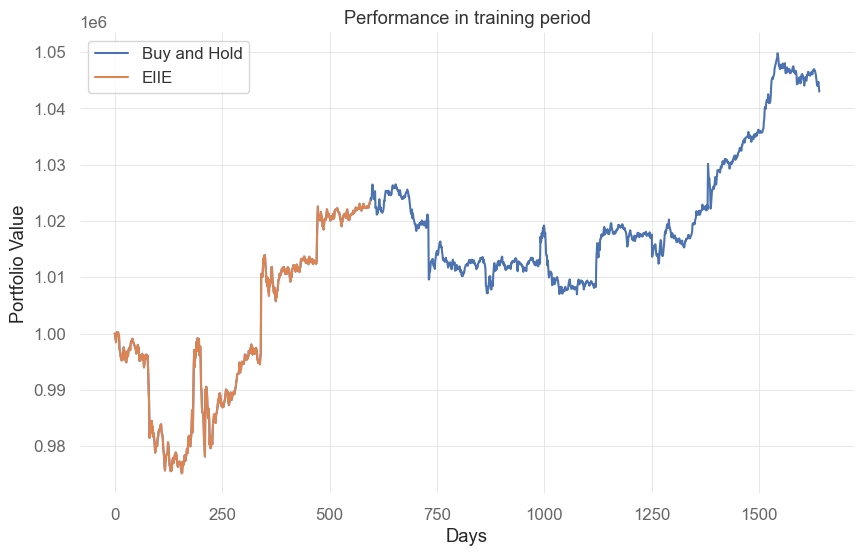

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

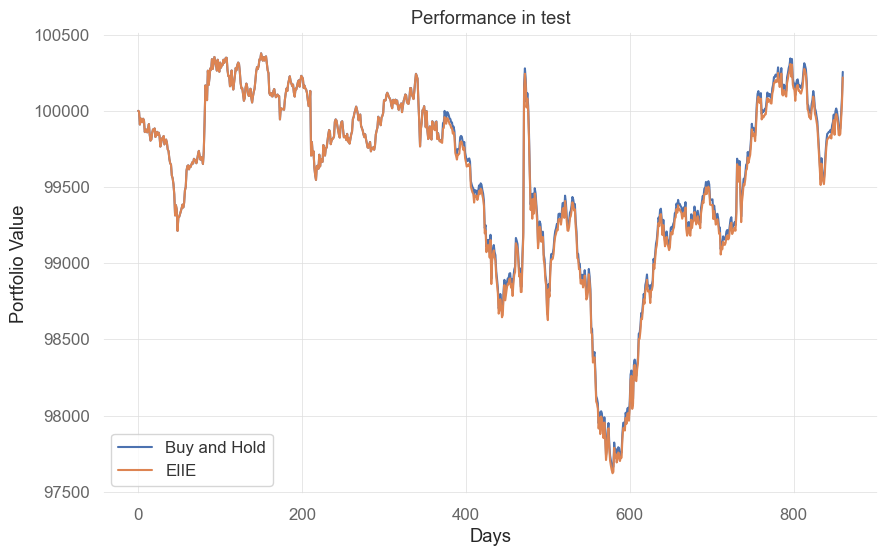

In [89]:
plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in test")
plt.legend()

plt.show()